<a href="https://colab.research.google.com/github/rclUPC/AdvancedFluidMechanics/blob/main/1-microFlows/MeniscusBetweenPlates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meniscus between plates. Solution


Find the shape for two parallels walls separated a distance $L$

Hint: In the middle point between both walls, curvature is not zero, so there is also there a pressure jump. This pressure jump is related, then, to the height of the column, $H$. It is suggested to change coordinate axes, as shown in the picture, and change the first equation as

$$ \frac{\rho g (z+H)}{\gamma} - \frac{z''}{\left(1 + {z'}^2\right)^{3/2}} = 0 $$

Also, there are 2 boundary conditions: the derivative of $z(x)$ for $x=-\frac{L}{2}$ and for $x=\frac{L}{2}$

![image.png](https://github.com/rclUPC/AdvancedFluidMechanics/blob/main/1-microFlows/MeniscusBetweenPlates.png?raw=1)

***

The exact solution of this problems can be found, both for planar and axisymmetric (capillary tube) can be found in [this paper by Liu et al.(2018)](https://link.springer.com/article/10.1140/epje/i2018-11648-1). We are going to find the shape with numerical integration, in a similar way as we have done with the shape with only one
plate.

We ca consider two method. In the first, we perform one integration of the second order ODE and the second is numerically integrated. In the second method, that is left as exercise, the second order ODE is written as a system of two first order ODE's and both are numerically integrated

## Method 1

In this method the origin of $x$ is at the wall and the numerical integration is done until the middle point between plates. All the variables are normalized with capillary length
$ l_s = \sqrt{\frac{\gamma}{\rho g}} $. Hence,

\begin{eqnarray}
\xi &=& \frac{x}{l_s} \\
\eta &=& \frac{z}{l_s} \\
\beta &=& \frac{H}{l_s} \\
\lambda &=& \frac{L}{l_s}
\end{eqnarray}

In [1]:
import numpy as np
import sympy as sp
from IPython.display import display,Math
sp.init_printing()

In [2]:
xi,theta, beta = sp.symbols('xi,theta,beta',positive=True)
eta = sp.Function('eta')
exp = (eta(xi)+beta)-eta(xi).diff(xi,2)/(1+eta(xi).diff(xi)**2)**(3/2)
display(Math(sp.latex(exp)+'= 0'))

<IPython.core.display.Math object>

As in the case of one plate, this equation can be integrated with an integration factor $\eta'$.

In [3]:
exp = exp*eta(xi).diff(xi)
display(Math(sp.latex(exp)+'= 0'))

<IPython.core.display.Math object>

In [4]:
exp2 = exp.integrate(xi)
display(Math(sp.latex(exp2)+r'= \text{constant}'))

<IPython.core.display.Math object>

Again, when $\eta=0$, the first derivative is $0$ too, so, this is again 1. And $\delta$, the normalized height of water in the wall (above center of meniscus) can be calculated by imposing its derivative.

In [5]:
dEq = sp.Eq(exp2,1)
display(dEq)
delta = sp.symbols('delta')
deltaEq = dEq.replace(eta(xi).diff(xi),-1/sp.tan(theta)).replace(eta(xi),delta)
display(deltaEq)

                              -0.5            
             ⎛          2    ⎞        2       
             ⎜⎛d       ⎞     ⎟       η (ξ)    
β⋅η(ξ) + 1.0⋅⎜⎜──(η(ξ))⎟  + 1⎟     + ───── = 1
             ⎝⎝dξ      ⎠     ⎠         2      

       2                    -0.5    
      δ        ⎛       1   ⎞        
β⋅δ + ── + 1.0⋅⎜1 + ───────⎟     = 1
      2        ⎜       2   ⎟        
               ⎝    tan (θ)⎠        

We keep the second solution, which is the positive one

In [6]:
deltaSol=sp.solve(deltaEq,delta)[1]
deltaSol.simplify().trigsimp()
display(Math('\delta ='+sp.latex(deltaSol)))

<IPython.core.display.Math object>

This is function of the contact angle ($\theta$) but also of the height of the column, $\beta$. The higher is $\beta$, the lower is $\delta$. This is because also $\lambda$ will be lower, and the meniscus is narrower.

We construct a function to calculate the numerical value of $\delta$ (initial value of $\eta$) with $\beta$ and $\theta$.

In [7]:
eta0_n = sp.lambdify((beta,theta),deltaSol)

and also, we construct the first order that we want to integrate, by defining the first derivative of $\eta$.

In [8]:
f = sp.solve(dEq,eta(xi).diff(xi))[0]
display(Math(r'\frac{\text{d}\eta}{\text{d}\xi} ='+sp.latex(f)))

<IPython.core.display.Math object>

and its numerical version

In [9]:
deta_dxi = sp.lambdify((xi,eta(xi),beta),f)

and now we can integrate it, choosing input values for contact angle $\theta$ and for $\beta$ (height of column). The function used to numerically the EDO is `scipy.integrate.solve_ivp` (for *Initial Value Problem*).

In [10]:
from scipy.integrate import solve_ivp
theta_n = np.deg2rad(30)
beta_n = 0.1
eta0 = sp.N(eta0_n(beta_n,theta_n),4)
display(eta0)

0.9050

An estimation of distance between plates can be done easily with the circular approximation, yielding $\lambda = \frac{2\cos{\theta}}{\beta}$. So, the distance to the middle point will be less than $\frac{\cos{\theta}}{\beta}$. This distance can also be computed assuimint that $\eta(\xi) = 0 \; \forall \; \xi$ and the weigth of the column is only due to the liquid mass below $z=0$.

The function `solve_ivp` takes 3 main arguments:
- The function defining the derivative of $\eta$ (in our case, deta_dxi) that has to be as f(t,x(t)) (Note the the first argument as to be the independent variable, $t$ or $\xi$ and the second the function to be computed, $y(t)$, or $\eta(\xi)$.
- The interval of computation.
- The initial value or values.

The other arguments are the points where we want the function to be evaluated and the extra parameter that has to be passed to the function deta_dxi.

In [11]:
l_2_est = np.cos(theta_n)/beta_n
xi_p = np.linspace(0,l_2_est,1000) # long enough for our case
sol_eta = solve_ivp(deta_dxi,(xi_p[0],xi_p[-1]),[eta0],t_eval=xi_p,args=(beta_n,))

<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(-1.0 + 1.0/(0.5*_Dummy_1562**2 + _Dummy_1562*beta - 1)**2)


It can ouput a warning because the derivative can gives imaginary values (negative argument in the root square) but it is not important.

The real value of $\lambda$ is obtained by computing the real weigth of the column and equating it to the surface tension. In dimensionless form, it is written as
$$  \int_0^{\lambda/2}\eta(\xi)\text{d}\xi + \beta \frac{\lambda}{2} = \cos(\theta) $$
$$ \Rightarrow \; \frac{\lambda}{2} = \frac{1}{\beta}\left(\cos(\theta) - \int_0^{\lambda/2}\eta(\xi)\text{d}\xi \right) $$

Don't worry about the limit of integration in $\eta(\xi)$, since $\eta(\xi) = 0$ for $\xi>\lambda/2$. So, the integration can be done in all the computed interval.



`solve_ivp` outputs more information than just the solution

The evaluation points are stored in `sol_eta.t`, and the solution in `sol_eta.y` that is, actually an array of arrays and, in our case, we have only one.

In [12]:
eta_np = sol_eta.y[0]
xi_np = sol_eta.t

In [13]:
l_2 = (np.cos(theta_n) - np.trapz(eta_np,xi_np))/beta_n
print('numerical value for lambda: {:.3g}'.format(l_2*2))
print('estimated value for lambda: {:.3g}'.format(l_2_est*2))

numerical value for lambda: 5.59
estimated value for lambda: 17.3


We keep only the values corresponding to $\xi < \lambda/2$

In [14]:
xi_np = xi_np[sol_eta.t < l_2] # [xi_np < l_2] indentifies the indexes where the condition is fulfilled
eta_np = eta_np[sol_eta.t < l_2]

In [15]:
R = l_2/np.cos(theta_n)
eta_circ = R - np.sqrt(R**2 - (l_2-xi_np)**2)

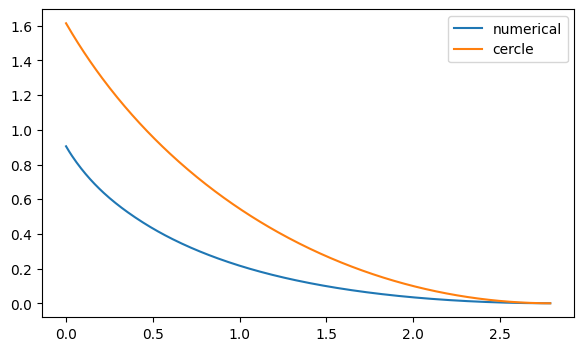

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,4))
plt.gca().set_aspect('equal', adjustable='box')
ax.plot(xi_np,eta_np,scaley=True, label='numerical')
ax.plot(xi_np,eta_circ,scaley=True, label ='cercle')
ax.legend()

## Method 2 (still an exercise for the student)

In this method, we write the second order ODE as a system of two first order ODE's:

$$
\eta'(\zeta,\eta,\xi) = \zeta(\xi)
$$
$$
\zeta'(\zeta,\eta,\xi) = (\eta(\xi) + \beta)\left(1+\zeta(\xi)^2\right)^\frac{3}{2}
$$


and, if the coordinates are centered in the middle point (as indicated in the figure), the initial conditions are $\eta(\xi=0)=\zeta(\xi=0)=0$.

_Question:_ How do we calculate the value of $\lambda$?